# PCA and the relationship with MV = PY


### Lessons to cover and objectives:

- Monetarist Economic Theory (MV = PY function)
- Simple Data Wrangling
- Time Series Visualizations
- PCA 
- Biplot interpretations

I am not going to conduct any cross validation, this is an interpretibility exploration of economic theory applying Machine Learning theory. 

I conducted this experiment because of the recent price debasement argument since money supply injections by the central bank are reaching all time highs, as you'll note in the data. 

In [1]:
import pandas as pd
import os
from plotly import express
import datetime as dt
import numpy as np
import seaborn as sn
from sklearn.decomposition import PCA

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
os.getcwd()

'/Users/nicoogawa/Documents/Data/MVPY'

In [3]:
path = '/Users/nicoogawa/Documents/Data/MVPY/data'
# Make sure to not hardtype
os.chdir(path)

csvlist = os.listdir(path)
csvlist.remove('.DS_Store')

All of the data gathered here was from FRED. I have converted everything into similar date formats (Quarterly)

In [4]:
df = pd.read_csv('CPI.csv', index_col = 'DATE')
df.index = pd.to_datetime(df.index)

for csvfile in csvlist[1:]:
    dfnew = pd.read_csv(csvfile, index_col = 'DATE')
    dfnew.index = pd.to_datetime(dfnew.index)
    df = pd.merge(df, dfnew, on = "DATE")
    
df

,CPIAUCSL,GDPC1,M2V,M2SL
DATE,,,,
1959-01-01,28.9933333333333333,3121.936,1.773,287.8333333333333333
1959-04-01,29.0433333333333333,3192.380,1.789,292.1333333333333333
1959-07-01,29.1933333333333333,3194.653,1.773,296.1000000000000000
1959-10-01,29.3700000000000000,3203.759,1.779,297.1333333333333333
1960-01-01,29.3966666666666667,3275.757,1.817,298.7000000000000000
...,...,...,...,...
2019-04-01,255.1706666666666667,19020.599,1.454,14665.200000000000
2019-07-01,256.3246666666666667,19141.744,1.442,14939.433333333333
2019-10-01,257.8323333333333333,19253.959,1.427,15236.033333333333


Always check the datatypes. We need to do two transformations the dataset. Firstly, we need to normalize the data when using PCA. A feature about PCA is that un-normalized data will lead to an algorithm where the highest variance feature will be weighted the largest in the principal component scores. If this assumption does not hold for your data, normalize the data. Although observing the data loses a bit of its interpretability from first glance, it still offers some key insights. 


So lets first put the data into percentile terms before we normalize it. Since each observation depends on the previous observation(the money supply this year depends on last year's money supply), we need to first take the rate of change to ensure the mean of each feature is appropriately calculated. 

In [5]:
df.dtypes

CPIAUCSL     object
GDPC1       float64
M2V         float64
M2SL         object
dtype: object

In [6]:
# Change data types
df['CPIAUCSL'] = df['CPIAUCSL'].astype('float')
df['M2SL'] = df['M2SL'].astype('float')

In [7]:
df = df.pct_change()
# This will always leave you with the first row as na
df = df.dropna()

In [8]:
df

,CPIAUCSL,GDPC1,M2V,M2SL
DATE,,,,
1959-04-01,0.001725,0.022564,0.009024,0.014939
1959-07-01,0.005165,0.000712,-0.008944,0.013578
1959-10-01,0.006052,0.002850,0.003384,0.003490
1960-01-01,0.000908,0.022473,0.021360,0.005273
1960-04-01,0.006010,-0.005394,-0.011007,0.008035
...,...,...,...,...
2019-04-01,0.007483,0.003707,-0.003427,0.013474
2019-07-01,0.004522,0.006369,-0.008253,0.018700
2019-10-01,0.005882,0.005862,-0.010402,0.019853


In [9]:
df.columns = ['Pct_Infl', 'Pct_GDP', 'Pct_Vel', 'Pct_M2']

In [10]:
df.dtypes

Pct_Infl    float64
Pct_GDP     float64
Pct_Vel     float64
Pct_M2      float64
dtype: object

I'll do a bit of EDA. A couple plots may help us visualize 

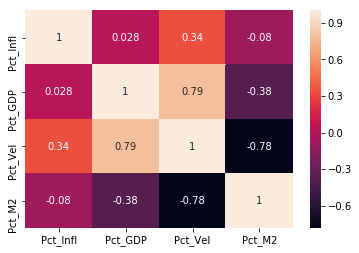

In [11]:
sn.heatmap(df.corr(), annot=True)
plt.show()

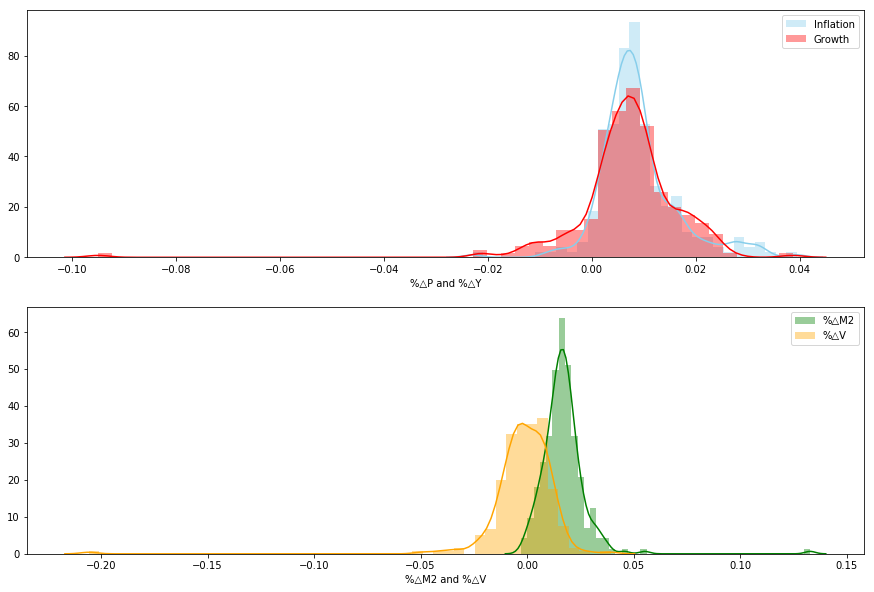

In [12]:
import seaborn as sns
f, axes = plt.subplots(2, 1, figsize=(15, 10))

sns.distplot( df["Pct_Infl"] , color="skyblue", label="Inflation",ax=axes[0])
sns.distplot( df["Pct_GDP"] , color="red", label="Growth",ax=axes[0])
sns.distplot( df["Pct_M2"] , color="green", label="%△M2",ax=axes[1])
sns.distplot( df["Pct_Vel"] , color="orange", label="%△V",ax=axes[1])

axes[0].legend()
axes[1].legend()

axes[0].set_xlabel('%△P and %△Y');
axes[1].set_xlabel('%△M2 and %△V');


I don't want to bore anyone with distribution jargon, but all the distributions look relatively normal. But there are couple things worth noting, 

1. The left tail of Velocity has some sicnificant outliers
2. The right tail of M2 has some sicnifigant outliers (I smell Quantitative Easing)

- Essentially, using MV = PY. You can do a very common maneuver in economics, put both sides in log form and take the derivative. This process will leave you with the equation of:


### %△M + %△P = %△V + %△Y

- Alright, lets see if this empirically holds.

### The relationship of %△M + %△P = %△V + %△Y

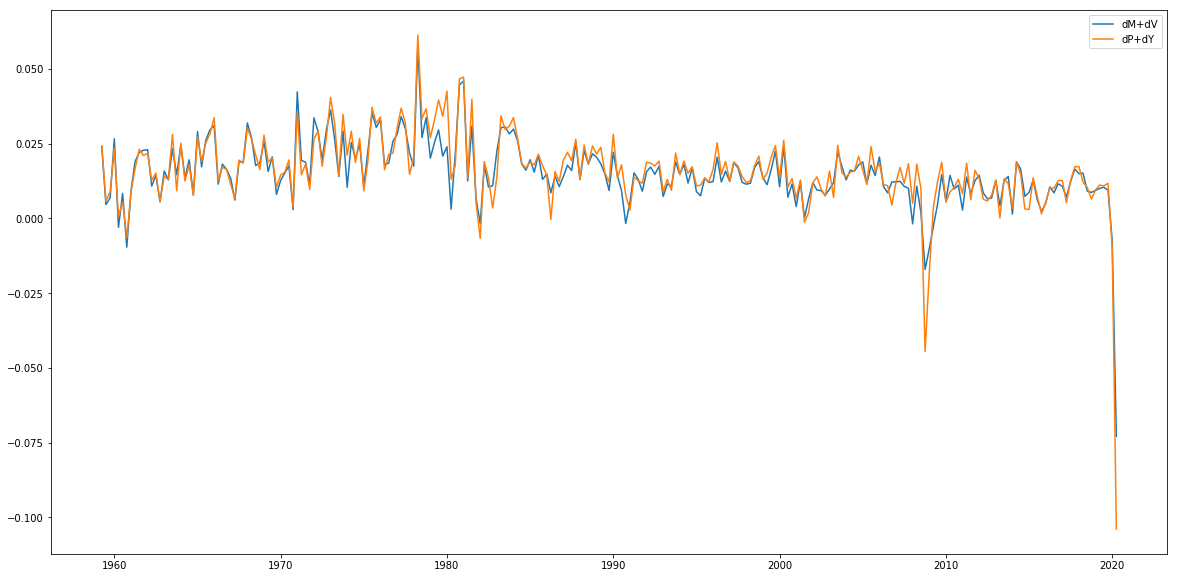

In [13]:
dfpc = pd.DataFrame()

plt.figure(figsize=(20,10));
dfpc['dM+dV'] = df.Pct_M2 + df.Pct_Vel 
dfpc['dP+dY'] = df.Pct_GDP + df.Pct_Infl 
plt.plot(dfpc)
plt.legend(dfpc); 

Pretty impressive, the theory is accurate from first glance. Let's look for outliers where the deviations from the equation exceed a 1% threshold

In [14]:
spread = dfpc[abs(dfpc['dM+dV'] - dfpc['dP+dY']) > 0.01]
spread 

,dM+dV,dP+dY
DATE,,
1974-01-01,0.010402,0.021156
1979-10-01,0.020836,0.034161
1980-01-01,0.023985,0.042602
1980-04-01,0.003105,0.013136
2008-10-01,-0.017034,-0.044540
2020-04-01,-0.072874,-0.103891


Worth noting, I had made the dataframe names for this just dP, dY, dM, dY. This is not to be confused with the differential of this equation

In [15]:
df

,Pct_Infl,Pct_GDP,Pct_Vel,Pct_M2
DATE,,,,
1959-04-01,0.001725,0.022564,0.009024,0.014939
1959-07-01,0.005165,0.000712,-0.008944,0.013578
1959-10-01,0.006052,0.002850,0.003384,0.003490
1960-01-01,0.000908,0.022473,0.021360,0.005273
1960-04-01,0.006010,-0.005394,-0.011007,0.008035
...,...,...,...,...
2019-04-01,0.007483,0.003707,-0.003427,0.013474
2019-07-01,0.004522,0.006369,-0.008253,0.018700
2019-10-01,0.005882,0.005862,-0.010402,0.019853


We want to aggregate our data in yearly form, but firstly we need to ensure the data are correct. Taking the product of each quarter (Ie. 0.001725 * 0.005165 * 0.006052 ) will lead to an incorrect solution. We need to add a 1 to the data, below I use a function called annualize. 

Lambda functions confused me initially when learning Python. Lambda functions are just 1 line functions. I Commented out the in markdown below. 


In [16]:
#def annualize(x):
    #return x + 1
    
# Is the same as

#annualize = lambda x: x + 1

In [17]:
annualize = lambda x: x + 1
df = df.applymap(annualize) #applymap is a transformation conducted to all elements

In [18]:
dfyear = df.groupby(df.index.year).prod() #Taking the product

In [19]:
dfyear = dfyear.applymap(lambda x: x -1) #Subtracting off the 1 we originally had

Alas, we now have data on an annual basis. I back checked this data with St Louis FRED and the numbers were the same. 

In [20]:
dfyear.head(5)

,Pct_Infl,Pct_GDP,Pct_Vel,Pct_M2
DATE,,,,
1959,0.012991,0.026209,0.003384,0.032310
1960,0.013960,0.008818,-0.023609,0.046444
1961,0.007052,0.063958,0.002879,0.072041
1962,0.013004,0.043070,-0.023536,0.079700
1963,0.013935,0.051583,-0.017049,0.086413


Now lets normalize the data for PCA. Interpreting this data frame after this specific transformation is not as logical. 

For example, **Pct_Infl of 1959** equalling -0.810575 means this entry was -.81 standard deviations away from the mean value of Inflation Percentage. 

In [21]:
normalized_dfyear=(dfyear-dfyear.mean())/dfyear.std()
normalized_dfyear.head(5)

,Pct_Infl,Pct_GDP,Pct_Vel,Pct_M2
DATE,,,,
1959,-0.810575,-0.074875,0.249296,-1.220783
1960,-0.776684,-0.698687,-0.410721,-0.751680
1961,-1.018465,1.279143,0.236934,0.097924
1962,-0.810126,0.529918,-0.408945,0.352128
1963,-0.777567,0.835257,-0.250319,0.574936


# Using Principal Component Analysis for Interpretation

In [22]:
pca = PCA(n_components=2)
pca.fit(normalized_dfyear)
print(pca.explained_variance_ratio_)

[0.5004513  0.27487072]


## Principal Component Analysis biplot

I found myself a bit confused with PCA when I was first introduced to the subject. Although one part which demystified a lot of the mathematics behind it was the biplot. The biplot displays typically 2 parts, which are the *principal component loadings* and *principal component scores*, this plot can explain quite a bit in terms of observations and variable variations. Unfortunately, there are no packages which support an easy use of the biplot so the code for this particular plot can look a bit daunting. Below is an explanation of the code. We do not have the axes plotted for the loading vectors but the features are still visually reprepsented with their loading scores.

For a better explanation, I reccomend giving **"An Introduction to Statistical Learning" by Gareth James, Daniela Witten, Trevor Hastie and Robert Tibshirani a read. Specifically, Page 373-385**

Link: http://faculty.marshall.usc.edu/gareth-james/ISL/

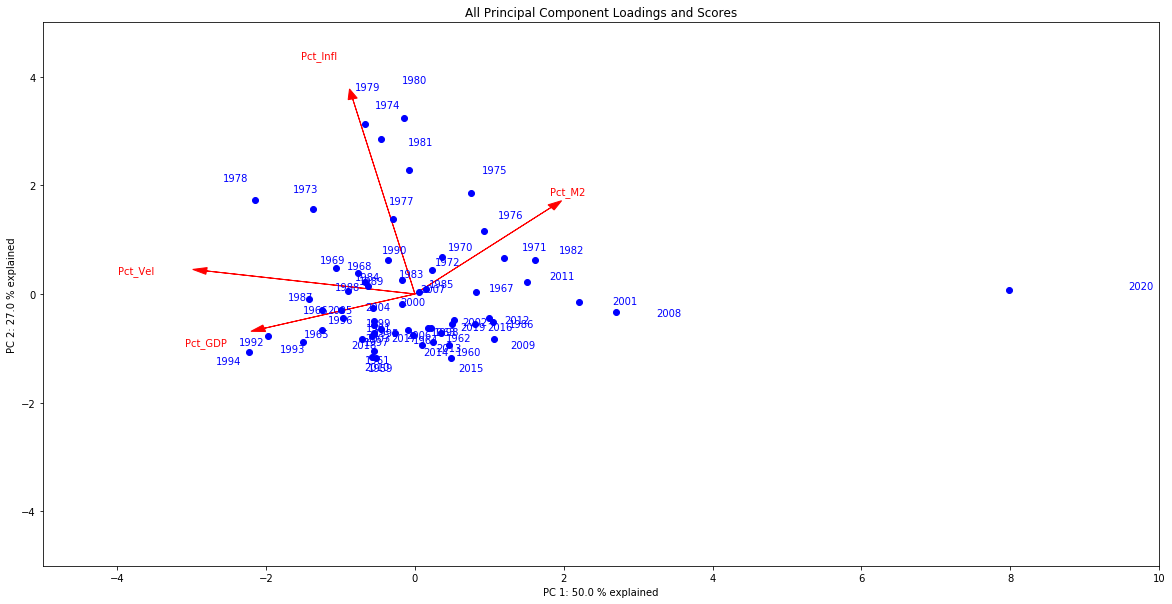

<Figure size 7200x3600 with 0 Axes>

In [23]:
plt.figure(figsize=(20,10))

xvector = pca.components_[0] 
yvector = pca.components_[1]

xs = pca.transform(normalized_dfyear)[:,0] 
ys = pca.transform(normalized_dfyear)[:,1]

plt.xlim((-5,10))
plt.ylim((-5,5))
plt.xlabel(f'PC 1: {round(pca.explained_variance_ratio_[0], 3) * 100} % explained')
plt.ylabel(f'PC 2: {round(pca.explained_variance_ratio_[1], 2) * 100} % explained')
plt.title('All Principal Component Loadings and Scores')


for i in range(len(xvector)):
    plt.arrow(0, 0, xvector[i]*4, yvector[i]*4,
              color='r', width=0.0005, head_width=0.125)
    plt.text(xvector[i]*5, yvector[i]*5,
             list(normalized_dfyear.columns.values)[i], color='r',horizontalalignment = 'right', verticalalignment = 'top')

for i in range(len(xs)):
    plt.plot(xs[i], ys[i], 'bo',)
    plt.text(xs[i]*1.2, ys[i]*1.2, list(normalized_dfyear.index)[i], color='b')

plt.figure(figsize=(100,50));
plt.show();

##### This plot is a bit messy with observations, lets look at observations with high scores in either principal component. To simplify, lets find observations where on the X or Y axis, they exceed a certain threshold. Let's use an arbitrary |1.7|. 

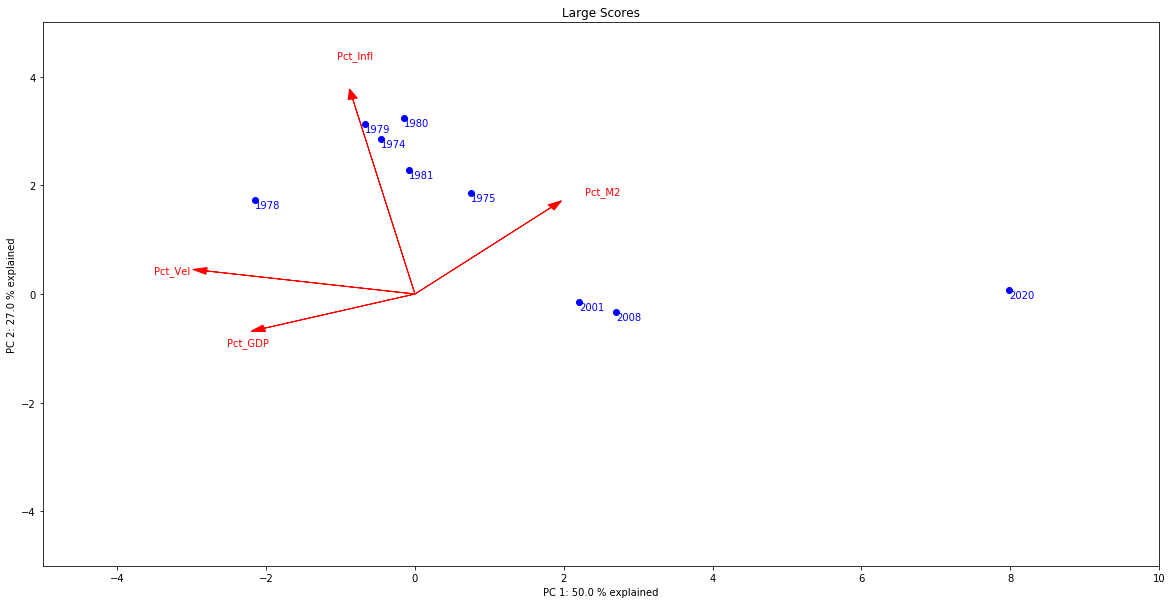

<Figure size 7200x3600 with 0 Axes>

In [24]:
plt.figure(figsize=(20,10))

xvector = pca.components_[0] 
yvector = pca.components_[1]

xs = pca.transform(normalized_dfyear)[:,0] 
ys = pca.transform(normalized_dfyear)[:,1]

plt.xlim((-5,10))
plt.ylim((-5,5))
plt.xlabel(f'PC 1: {round(pca.explained_variance_ratio_[0], 3) * 100} % explained')
plt.ylabel(f'PC 2: {round(pca.explained_variance_ratio_[1], 2) * 100} % explained')
plt.title('Large Scores')


for i in range(len(xvector)):
    plt.arrow(0, 0, xvector[i]*4, yvector[i]*4,
              color='r', width=0.0005, head_width=0.125)
    plt.text(xvector[i]*5, yvector[i]*5,
             list(normalized_dfyear.columns.values)[i], color='r', verticalalignment = 'top')

for i in range(len(xs)):
    if ys[i] > abs(1.7) or xs[i] > abs(1.7):
        plt.plot(xs[i], ys[i], 'bo',)
        plt.text(xs[i], ys[i], list(normalized_dfyear.index)[i], color='b', verticalalignment = 'top')

plt.figure(figsize=(100,50));
plt.show();

# Interpretation

#### For Principal Component 1 which explains 50% of the variation.

The first principal component loading vector places all of it's postive weight onto `Pct_M2`, while `Pct_Vel` and `Pct_GDP` are negative. It is clear that observations 2008 and 2020 have large positive scores on the first principal component, meaning there is large injections of money supply while having sicnigant drops in the percentage change in velocity and the percentage change in GDP. Since the inflation feature has a score close to 0, it is insicnifigant in determining the variation in the first principal component. 

#### For Principal Component 2 which explains 27% of the variation.
The second principal component loading vector places most of it's positive weight on `Pct_infl` and much less weight on the other three features. Hence, this corresponds to the level of inflation of a given time period. Years/Observations  1979, 1980, 1984,and 1981 have large positive scores in the the second principal component. 

#### On The Princial Component Loading Scores
Firstly, the close distance between `Pct_Vel` and `Pct_GDP` indicates the velocity variable and GDP variable are correlated with eachother, and if you scroll up to the heat map, you actually notice the Correlation is 0.79. 

Second, The `Pct_M2` and `Pct_infl` have a negligible Euclidean distance. One can interpret that there is little correlation between the two, which by conventional theory or economic logic, seems a bit bizarre. One could add a lag of 1 year on the inflation to see if the relationship changed to observe if it is a lagged response. 

#### On the Differences between Observations
Our previous discussion of the loading vectors suggests that time periods with large positive scores on the first component, like 2008 or 2020, are facing huge liquidty injections (`Pct_M2`), with a sicnifigant recession and a drop in velocity. `t = 1978` has a negative score indicating



In [25]:
spread

,dM+dV,dP+dY
DATE,,
1974-01-01,0.010402,0.021156
1979-10-01,0.020836,0.034161
1980-01-01,0.023985,0.042602
1980-04-01,0.003105,0.013136
2008-10-01,-0.017034,-0.044540
2020-04-01,-0.072874,-0.103891


Noting, that all these observations are prevalent in the Principal Component Analysis